# Supervised Learning (Part 1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Rainfall Prediction Dataset

We will be using a dataset about **rainfall prediction** for **KNN, Logistic Regression, and SVM**.  

**Dataset overview:**
- Contains daily weather observations for various locations.
- Includes **numerical** and **categorical** measurements.
- Goal: Predict whether it will **rain the next day** (`RainTomorrow`).


## K-Nearest Neighbour

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [17]:
# Load CSV file
data = pd.read_csv('data/weatherAUS_rainfall_prediction_dataset_cleaned.csv')

# View the first 5 rows
print(data.head())

         Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2010-04-30  Adelaide     10.8     21.2       0.0          1.8      6.60   
1  2014-07-22  Adelaide      3.7     19.0       0.0          1.4      7.61   
2  2014-07-23  Adelaide      9.6     15.8       0.0          2.6      7.61   
3  2014-07-24  Adelaide     10.1     15.5      16.6          0.8      7.61   
4  2014-07-25  Adelaide     11.2     16.2       1.8          0.6      7.61   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0         ENE           22.0        ENE  ...        66.0         48.0   
1           N           24.0          N  ...        75.0         32.0   
2          NE           52.0        NNE  ...        35.0         51.0   
3         NNE           50.0         NW  ...        96.0         80.0   
4          NW           30.0        WNW  ...        89.0         70.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1028

In [ ]:
# Define features & target
# Features (independent variables)
X = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm']]

# Target (dependent variable)
y = data['RainTomorrow']

In [19]:
# Import library for train & test set split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

# Split dataset into training and testing sets
# test_size = 0.2 → 20% of data used for testing
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (116368, 7)
Test set shape: (29092, 7)


### Since KNN is distanced-based, it is important to scale the features

In [20]:
# Scale features to have mean=0 and std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create KNN classifier (k=5 nearest neighbors)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = knn_model.predict(X_test_scaled)

# Precision
print(f"Precision: {precision_score(y_test, y_pred, pos_label='Yes'):.2f}")

Precision: 0.65


### Now let's try to predict a few points using the knn model we formed

In [21]:
# Example test points for predicting RainTomorrow
test_days = pd.DataFrame({
    'MinTemp': [15, 8, 22, 12, 18],           # minimum temperature in °C
    'MaxTemp': [25, 18, 30, 20, 28],          # maximum temperature in °C
    'Rainfall': [0.0, 5.0, 0.0, 10.0, 2.5],   # rainfall in mm
    'Sunshine': [8.0, 3.5, 10.0, 2.0, 6.5],   # hours of sunshine
    'WindGustSpeed': [25, 40, 15, 30, 20],    # km/h
    'Humidity3pm': [45, 80, 35, 90, 60],      # %
    'Pressure3pm': [1020, 1005, 1015, 1008, 1018] # hPa
})

# Scale the new test points (as defined above under Logistic Regression)
test_days_scaled = scaler.transform(test_days)

# Predict class (0=No rain, 1=Rain)
pred_class = knn_model.predict(test_days_scaled)

# Predict probability
pred_prob = knn_model.predict_proba(test_days_scaled)

# Print results
for i, (cls, prob) in enumerate(zip(pred_class, pred_prob)):
    print(f"Day {i+1}: Predicted RainTomorrow = {cls}, Probability of rain = {prob[1]:.2f}")

Day 1: Predicted RainTomorrow = No, Probability of rain = 0.00
Day 2: Predicted RainTomorrow = Yes, Probability of rain = 1.00
Day 3: Predicted RainTomorrow = No, Probability of rain = 0.00
Day 4: Predicted RainTomorrow = Yes, Probability of rain = 1.00
Day 5: Predicted RainTomorrow = No, Probability of rain = 0.40


### Next, let's test a few k-values (using a loop) and see which one gives the best precision

In [22]:
precisions = []
k_values = list(range(25, 51, 2))  # odd k values

# Loop through odd k values and record precision
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    y_pred = knn_model.predict(X_test_scaled)
    
    # Compute precision (with "Yes" as positive class)
    prec = precision_score(y_test, y_pred, pos_label='Yes')
    precisions.append(prec)
    
    print(f"k = {k:2d} → Precision: {prec:.3f}")

k = 25 → Precision: 0.715
k = 27 → Precision: 0.716
k = 29 → Precision: 0.716
k = 31 → Precision: 0.719
k = 33 → Precision: 0.720
k = 35 → Precision: 0.722
k = 37 → Precision: 0.720
k = 39 → Precision: 0.724
k = 41 → Precision: 0.724
k = 43 → Precision: 0.724
k = 45 → Precision: 0.727
k = 47 → Precision: 0.729
k = 49 → Precision: 0.727


In [23]:
# Find best k (highest precision)
best_k = k_values[precisions.index(max(precisions))]
best_prec = max(precisions)
print(f"Best k = {best_k} with precision = {best_prec:.3f}")

Best k = 47 with precision = 0.729


### Let's visualise this on a plot

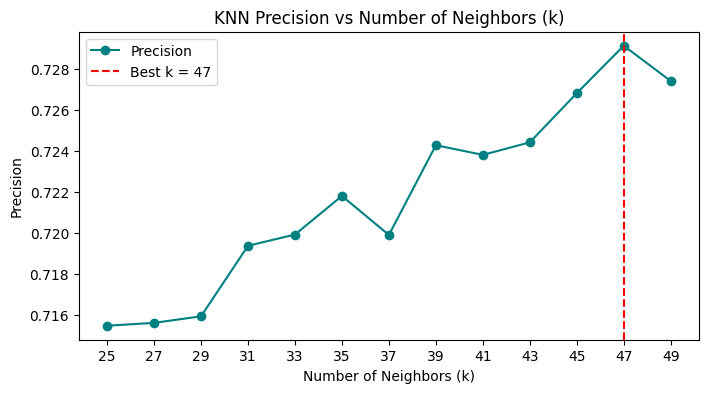

In [24]:
# Plot precision vs k
plt.figure(figsize=(8,4))
plt.plot(k_values, precisions, marker='o', linestyle='-', color='teal', label='Precision')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.title("KNN Precision vs Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Precision")
plt.xticks(k_values)
plt.legend()
plt.show()

### Overfitting and Underfitting (running this may take up to 5 mins+ so you can listen while it runs or run it after the workshop)

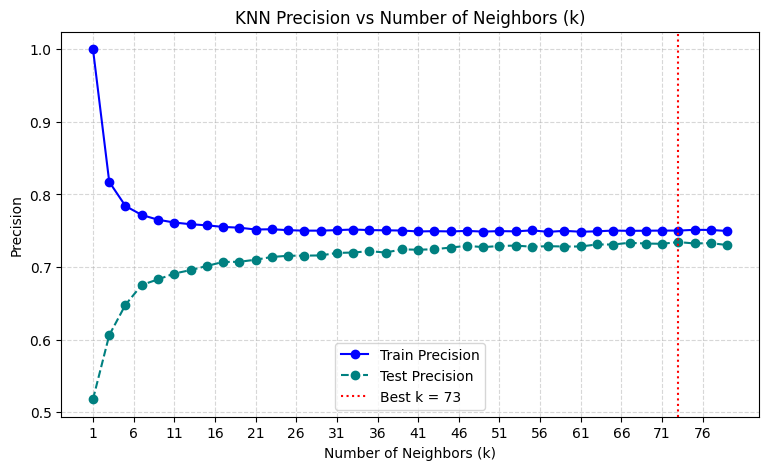

Best k (based on test precision): 73


In [ ]:
# Define odd k values from 1 to 79
k_values = list(range(1, 80, 2))

train_precisions = []
test_precisions = []

# Loop through each k value
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = knn_model.predict(X_train_scaled)
    y_test_pred = knn_model.predict(X_test_scaled)
    
    # Precision scores (with "Yes" as positive class)
    train_prec = precision_score(y_train, y_train_pred, pos_label='Yes')
    test_prec = precision_score(y_test, y_test_pred, pos_label='Yes')
    
    train_precisions.append(train_prec)
    test_precisions.append(test_prec)

# Find best k based on test precision
best_k = k_values[np.argmax(test_precisions)]

# Plot
plt.figure(figsize=(9, 5))
plt.plot(k_values, train_precisions, marker='o', linestyle='-', color='blue', label='Train Precision')
plt.plot(k_values, test_precisions, marker='o', linestyle='--', color='teal', label='Test Precision')
plt.axvline(best_k, color='red', linestyle=':', label=f'Best k = {best_k}')
plt.title("KNN Precision vs Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Precision")
plt.xticks(range(1, 80, 5))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"Best k (based on test precision): {best_k}")


# Linear Regression


In [26]:
# Load the library for linear regression
from sklearn.linear_model import LinearRegression


### Linear Transformation

In [27]:
# Generate & create dataset
np.random.seed(42)  
x = np.linspace(1, 100, 100) 
y = 5 * np.log(x) + np.random.normal(0, 0.5, size=x.shape)
df = pd.DataFrame({'x': x, 'y': y})

### Plot y against x (WITHOUT transformation)

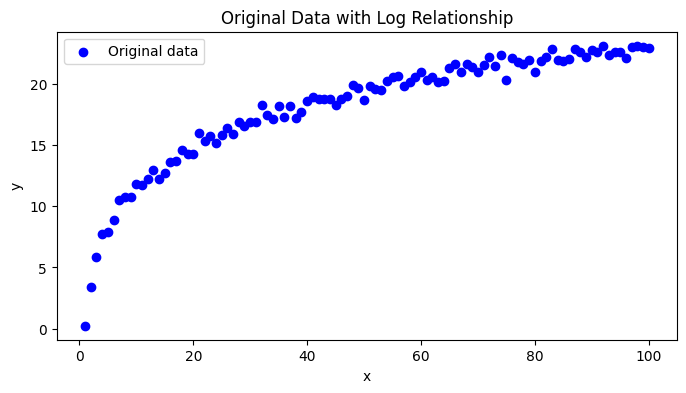

In [28]:
plt.figure(figsize=(8, 4))
plt.scatter(df['x'], df['y'], color='blue', label='Original data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data with Log Relationship')
plt.legend()
plt.show()

### Apply Log Transformation to X

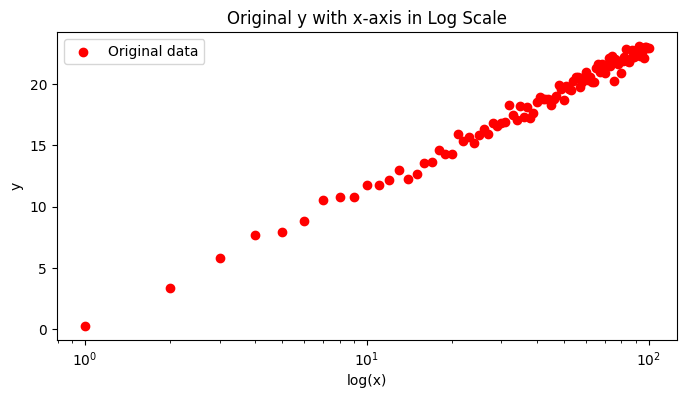

In [29]:
plt.figure(figsize=(8, 4))
plt.scatter(df['x'], df['y'], color='red', label='Original data')
plt.xscale('log')   # <--- log scale here
plt.xlabel('log(x)')
plt.ylabel('y')
plt.title('Original y with x-axis in Log Scale')
plt.legend()
plt.show()

### House Price Prediction Dataset

We will use a **different dataset** for **Linear Regression**.  

**Dataset overview:**
- Contains information about **houses**, including:
  - Physical characteristics (e.g., size, number of rooms)
  - Location
  - Pricing
- Goal: Predict the **house price** based on these features.


## Linear Regression for Predicing

In [30]:
# Load CSV file
data = pd.read_csv('data/house_selling_prices_FL.csv')

# View the first 5 rows
print(data.head())


   House  Taxes  Bedrooms  Baths Quadrant  NW   price  size    lot
0      1   1360         3    2.0       NW   1  145000  1240  18000
1      2   1050         1    1.0       NW   1   68000   370  25000
2      3   1010         3    1.5       NW   1  115000  1130  25000
3      4    830         3    2.0       SW   0   69000  1120  17000
4      5   2150         3    2.0       NW   1  163000  1710  14000


In [31]:
# Select input (X) and output (y)
X = data[['size']]  # input 
y = data['price']   # output

# Create and train the linear regression model
model = LinearRegression()
model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


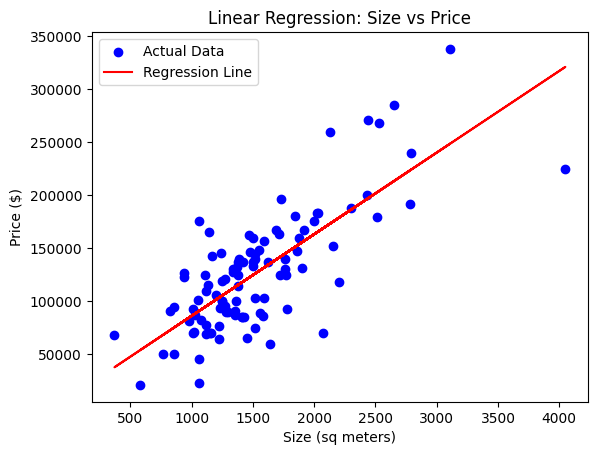

Slope (w1): 77.01
Intercept (w0): 9161.16


In [32]:
# Predict on training data for plotting
y_pred_train = model.predict(X)

# Plot actual data and regression line
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, y_pred_train, color='red', label='Regression Line')
plt.xlabel('Size (sq meters)')
plt.ylabel('Price ($)')
plt.title('Linear Regression: Size vs Price')
plt.legend()
plt.show()

# Print slope and intercept
print(f"Slope (w1): {model.coef_[0]:.2f}")
print(f"Intercept (w0): {model.intercept_:.2f}")

In [33]:
# Predicting new data points 
X_new = pd.DataFrame({'size': [1500, 2000, 2500]})
y_new_pred = model.predict(X_new)

for x, y in zip(X_new['size'], y_new_pred):
    print(f"The house of size {x} sq meters has a price of ${y:.2f}")

The house of size 1500 sq meters has a price of $124672.70
The house of size 2000 sq meters has a price of $163176.54
The house of size 2500 sq meters has a price of $201680.39


# Logistic Regression

In [34]:
# Import library for logistic regression
from sklearn.linear_model import LogisticRegression


In [35]:
# Load CSV file
data = pd.read_csv('data/weatherAUS_rainfall_prediction_dataset_cleaned.csv')

# View the first 5 rows
print(data.head())

         Date  Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2010-04-30  Adelaide     10.8     21.2       0.0          1.8      6.60   
1  2014-07-22  Adelaide      3.7     19.0       0.0          1.4      7.61   
2  2014-07-23  Adelaide      9.6     15.8       0.0          2.6      7.61   
3  2014-07-24  Adelaide     10.1     15.5      16.6          0.8      7.61   
4  2014-07-25  Adelaide     11.2     16.2       1.8          0.6      7.61   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0         ENE           22.0        ENE  ...        66.0         48.0   
1           N           24.0          N  ...        75.0         32.0   
2          NE           52.0        NNE  ...        35.0         51.0   
3         NNE           50.0         NW  ...        96.0         80.0   
4          NW           30.0        WNW  ...        89.0         70.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1028

In [50]:
# Define features & target
# Features (independent variables)
X = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm']]

# Target (dependent variable)
y = data['RainTomorrow']


In [56]:
# Split dataset into training and testing sets
# test_size = 0.2 → 20% of data used for testing
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model using training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 2))

Accuracy: 0.84


### Predicting Sample Points with Logistic Regression

We will use **Logistic Regression** to predict the **same sample points** that were used in the **KNN example**.

In [55]:
# Example test points for predicting RainTomorrow
test_days = pd.DataFrame({
    'MinTemp': [15, 8, 22, 12, 18],           # minimum temperature in °C
    'MaxTemp': [25, 18, 30, 20, 28],          # maximum temperature in °C
    'Rainfall': [0.0, 5.0, 0.0, 10.0, 2.5],   # rainfall in mm
    'Sunshine': [8.0, 3.5, 10.0, 2.0, 6.5],   # hours of sunshine
    'WindGustSpeed': [25, 40, 15, 30, 20],    # km/h
    'Humidity3pm': [45, 80, 35, 90, 60],      # %
    'Pressure3pm': [1020, 1005, 1015, 1008, 1018] # hPa
})

# Scale the new test points using the same scaler
test_days_scaled = scaler.transform(test_days)

# Predict class (0 = no disease, 1 = disease)
pred_class = model.predict(test_days)

# Predict probability
pred_prob = model.predict_proba(test_days)

# Print nicely
for i, (cls, prob) in enumerate(zip(pred_class, pred_prob)):
    print(f"Day {i+1}: Predicted RainTomorrow = {cls}, Probability of rain = {prob[1]:.2f}")


Day 1: Predicted RainTomorrow = No, Probability of rain = 0.04
Day 2: Predicted RainTomorrow = Yes, Probability of rain = 0.79
Day 3: Predicted RainTomorrow = No, Probability of rain = 0.02
Day 4: Predicted RainTomorrow = Yes, Probability of rain = 0.84
Day 5: Predicted RainTomorrow = No, Probability of rain = 0.12


# SVM

In [57]:
# Import library for SVM
from sklearn.svm import SVC

In [40]:
# Define features & target (we will use less features as SVM model has a long training time)

# Features (independent variables)
X = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm']]

# Target (dependent variable)
y = data['RainTomorrow']

### Subsampling the Data for SVM

We will use **only 40% of the dataset** for training and testing.  
This reduces the dataset size and speeds up training, as the **SVM model can take a long time** on larger datasets.


In [41]:
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.4, random_state=42)

# Then split this smaller dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)


### SVM is also distance-based, so feature scaling is very important.

In [42]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### The model might take some time to form since it's trained on a large dataset

In [43]:
# Create SVM classifier with RBF kernel
# kernel='rbf' is the default and works well for non-linear boundaries.
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Accuracy: 0.85


### The accuracy for SVM is slightly higher than logistic regression, which may be due to multiple reasons:

- **Non-linear decision boundaries:**  
  SVM with an RBF kernel can capture complex, curved relationships in the data, while logistic regression assumes a straight linear boundary.

- **Kernel trick:**  
  The RBF kernel maps data into a higher-dimensional space, allowing SVM to separate classes that are not separable in the original feature space.


### Predict on datapoints

In [44]:
# Example test points for predicting RainTomorrow
test_days = pd.DataFrame({
    'MinTemp': [15, 8, 22, 12, 18],           # minimum temperature in °C
    'MaxTemp': [25, 18, 30, 20, 28],          # maximum temperature in °C
    'Rainfall': [0.0, 5.0, 0.0, 10.0, 2.5],   # rainfall in mm
    'Sunshine': [8.0, 3.5, 10.0, 2.0, 6.5],   # hours of sunshine
    'WindGustSpeed': [25, 40, 15, 30, 20],    # km/h
    'Humidity3pm': [45, 80, 35, 90, 60],      # %
    'Pressure3pm': [1020, 1005, 1015, 1008, 1018] # hPa
})

# Scale the new test points
test_days_scaled = scaler.transform(test_days)

# Predict class (0=No rain, 1=Rain)
pred_class = svm_model.predict(test_days_scaled)

# Predict probability
pred_prob = svm_model.predict_proba(test_days_scaled)

# Print results
for i, (cls, prob) in enumerate(zip(pred_class, pred_prob)):
    print(f"Day {i+1}: Predicted RainTomorrow = {cls}, Probability of rain = {prob[1]:.2f}")


Day 1: Predicted RainTomorrow = No, Probability of rain = 0.12
Day 2: Predicted RainTomorrow = Yes, Probability of rain = 0.96
Day 3: Predicted RainTomorrow = No, Probability of rain = 0.09
Day 4: Predicted RainTomorrow = Yes, Probability of rain = 0.97
Day 5: Predicted RainTomorrow = No, Probability of rain = 0.12


### To visualise the hyperplane

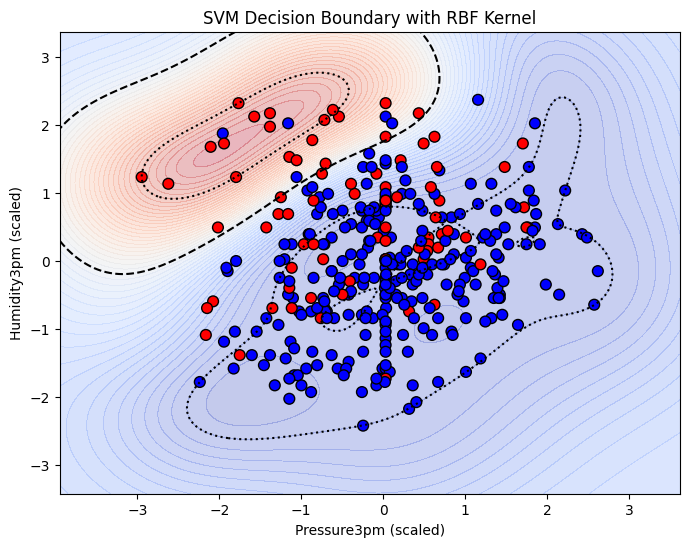

In [45]:
# Use only 0.3% of the dataset for fast visualization
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.003, random_state=42)

# Select 2 features for 2D visualization
X_vis = X_small[['Pressure3pm', 'Humidity3pm']].values
y_vis = y_small.map({'No': 0, 'Yes': 1}).values  # convert labels to 0/1

# Split and scale
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y_vis, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_vis = scaler.fit_transform(X_train_vis)
X_test_vis = scaler.transform(X_test_vis)

# Train SVM with RBF kernel
svm_vis = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm_vis.fit(X_train_vis, y_train_vis)

# Create a smaller grid for faster plotting
xx, yy = np.meshgrid(
    np.linspace(X_train_vis[:, 0].min() - 1, X_train_vis[:, 0].max() + 1, 200),
    np.linspace(X_train_vis[:, 1].min() - 1, X_train_vis[:, 1].max() + 1, 200)
)

Z = svm_vis.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))

# Contour plot of decision function (hyperplane + margins)
plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.3)
plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--')   # hyperplane
plt.contour(xx, yy, Z, levels=[-1, 1], colors='k', linestyles=':') # margins

# Scatter plot of training points
plt.scatter(
    X_train_vis[:, 0], X_train_vis[:, 1],
    c=y_train_vis, cmap='bwr', edgecolors='k', s=60
)

# Correct axis labels
plt.xlabel('Pressure3pm (scaled)')
plt.ylabel('Humidity3pm (scaled)')
plt.title('SVM Decision Boundary with RBF Kernel')
plt.show()


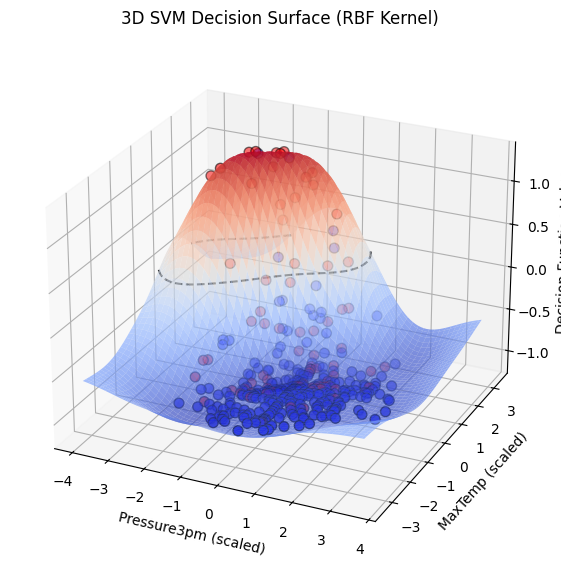

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Create mesh grid using the same 2 features
xx, yy = np.meshgrid(
    np.linspace(X_train_vis[:, 0].min() - 1, X_train_vis[:, 0].max() + 1, 100),
    np.linspace(X_train_vis[:, 1].min() - 1, X_train_vis[:, 1].max() + 1, 100)
)

# Compute decision function values
Z = svm_vis.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the SVM decision surface
ax.plot_surface(xx, yy, Z, cmap='coolwarm', alpha=0.7, linewidth=0, antialiased=True)

# Plot training points in 3D (z = decision function)
ax.scatter(
    X_train_vis[:, 0], X_train_vis[:, 1],
    svm_vis.decision_function(X_train_vis),
    c=y_train_vis, cmap='bwr', edgecolor='k', s=50
)

# Highlight the decision boundary (Z=0)
ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', offset=0)

# Axis labels and view
ax.set_xlabel('Pressure3pm (scaled)')
ax.set_ylabel('Humidity (scaled)')
ax.set_zlabel('Decision Function Value')
ax.set_title('3D SVM Decision Surface (RBF Kernel)')
ax.view_init(elev=25, azim=295)

plt.show()
